<a href="https://colab.research.google.com/github/Shivam10816/CS22M082_ASSIGNEMNT_1/blob/q2/March_10__neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install wandb
import wandb
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import numpy as np
import random
from keras.datasets import fashion_mnist

(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

Error in callback <function _WandbInit._resume_backend at 0x7f6bd9b5d040> (for pre_run_cell):


BrokenPipeError: ignored

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Error in callback <function _WandbInit._pause_backend at 0x7f6bd9b5d4c0> (for post_run_cell):


BrokenPipeError: ignored

wandb: Currently logged in as: shivam-kharat-94 (vilgax). Use `wandb login --relogin` to force relogin


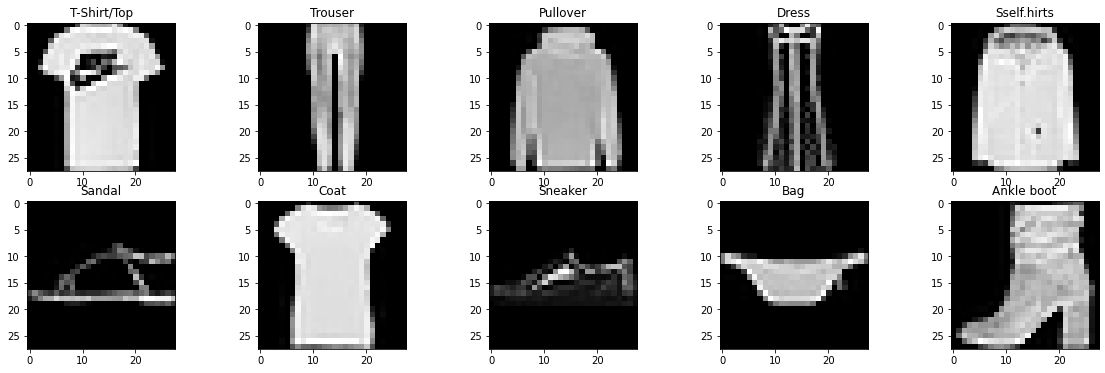

In [2]:
wandb.init(project = "Assignment 1_new" ,name = "Question 1")


titles = ["T-Shirt/Top","Trouser","Pullover","Dress","Sself.hirts","Sandal","Coat","Sneaker","Bag","Ankle boot"]
fig,axs = plt.subplots(2,5,figsize=(20,6))
axs =axs.flatten()
images=[]
for i in range(0,10):
  index =random.choice(np.where(train_labels==i)[0])
  
  axs[i].imshow(train_data[index],cmap="gray")
  axs[i].set_title(titles[i])
  Img = wandb.Image(train_data[index],caption=[titles[i]])
  images.append(Img)
wandb.log({"examples":images})
  

In [ ]:

train_data = np.reshape(train_data,(len(train_data),train_data.shape[1]**2))
test_data = np.reshape(test_data,(len(test_data),test_data.shape[1]**2))
test_labels =np.reshape(test_labels,(1,len(test_data)))


# **Question 2/3**

In [3]:
import torch.nn.init as init
import torch
from numpy.core.multiarray import MAY_SHARE_EXACT
from re import M
from matplotlib.lines import STEP_LOOKUP_MAP
from sklearn.metrics import confusion_matrix

(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()
train_data = np.reshape(train_data/255.0,(len(train_data),train_data.shape[1]**2))
test_data = np.reshape(test_data/255.0,(len(test_data),test_data.shape[1]**2))
test_labels =np.reshape(test_labels,(1,len(test_data)))


class neural_network:

  #it initializes W and b
  def __init__(self):
    
    (train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()
    train_data = np.reshape(train_data/255.0,(len(train_data),train_data.shape[1]**2))
    self.test_data = np.reshape(test_data/255.0,(len(test_data),test_data.shape[1]**2))
    self.test_labels =test_labels #np.reshape(test_labels,(1,len(test_data)))

    l=int(train_data.shape[0]/100)*80
    self.train_data=train_data[0:l]
    self.train_label=train_labels[0:l]
    self.validation_data = train_data[l:]
    self.validation_label = train_labels[l:]
    
  #def train(self,epoch=10,hidden_layers=3,size_of_layer=32,weight_decay=0,learning_rate=0.01,optimizer="sgd",batch_size=32,weight_init="random",activation="sigmoid"):

  def train(self,weight_init="random",hidden_layers=3,size_of_layer=32,activation="sigmoid",optimizer="sgd",learning_rate=0.01,epoch=10,batch_size=32,weight_decay=0,loss="cross_entropy"):
    
    np.random.seed(42)
    self.loss = loss
    self.hi=[size_of_layer]*hidden_layers
    self.activation =activation
    if(weight_init=="Xavier"):
      self.xav()
    elif(weight_init=="random"):
      self.rndm()
   
    if(optimizer=="sgd"):
      self.sgd(step_size=learning_rate,batch_size =batch_size,epoch=epoch,reg=weight_decay)
    elif(optimizer=="momentum"):
      self.mbgd(step_size=learning_rate,batch_size =batch_size,epoch=epoch,beta=0.75,reg=weight_decay)
    elif(optimizer=="nesterov"):
      self.nagd(step_size=learning_rate,batch_size =batch_size,epoch=epoch,reg=weight_decay)
    elif(optimizer=="rmsprop"):
      self.rmsprop(step_size=learning_rate,batch_size =batch_size,epoch=epoch,reg=weight_decay)
    elif(optimizer=="adam"):
      self.adam(step_size=learning_rate,batch_size =batch_size,epoch=epoch,reg=weight_decay)
    elif(optimizer=="nadam"):
      self.nadam(step_size=learning_rate,batch_size =batch_size,epoch=epoch,reg=weight_decay)
    
    


    


  def xav(self):
    l= self.train_data.shape[1]

    self.W =[self.xavier_init(self.hi[0],l)] 
    self.b =[self.xavier_init(1,self.hi[0])]
    for i in range(1,len(self.hi)) :
      self.W.append(self.xavier_init(self.hi[i],self.hi[i-1]))
      self.b.append(self.xavier_init(1,self.hi[i])) 
    self.W.append(self.xavier_init(10,self.hi[-1]))
    
    self.b.append(self.xavier_init(1,10))
  

  def rndm(self):
    l= train_data.shape[1]

    self.W =[np.random.randn(self.hi[0],l)] 
    self.b =[np.random.randn(1,self.hi[0])]
    for i in range(1,len(self.hi)) :
      self.W.append(np.random.randn(self.hi[i],self.hi[i-1]))
      self.b.append(np.random.randn(1,self.hi[i])) 
    self.W.append(np.random.randn(10,self.hi[-1]))
    
    self.b.append(np.random.randn(1,10))

  def relu(self,matrix):

    """
    Arguments:
    matrix -- a NumPy array or matrix
    Returns:
    A NumPy array or matrix of the same shape as the input matrix,
    with ReLU applied to each element.
    """
    return np.maximum(matrix, 0) 

  def relu_derivative(self,matrix):
    
    # Create a copy of the input matrix and convert to float
    derivative = np.array(matrix, dtype=np.float64)
    
    # Set negative values to 0
    derivative[derivative < 0] = 0
    
    # Set positive values to 1
    derivative[derivative > 0] = 1

    return derivative

  def tanh(self,matrix):
    
    # Avoid overflow by scaling inputs to the range [-100, 100]
    x = np.clip(matrix, -100, 100)
    
    # Apply tanh element-wise
    return np.tanh(x)

  def tanh_derivative(self,matrix):
   
    # Avoid overflow by scaling inputs to the range [-100, 100]
    x = np.clip(matrix, -100, 100)
    
    # Compute tanh element-wise
    tanh_x = np.tanh(x)
    
    # Compute derivative of tanh element-wise
    derivative = 1 - tanh_x**2
    
    
    
    return derivative

 
  def WX_plus_B(self,W, X, b):
    
    result = np.dot(X, W.transpose())
    row_count = result.shape[0]
    
    row_matrix_repeated = np.tile(b, (row_count, 1))
    return result + row_matrix_repeated


  def xavier_init(self,n, m):
    # Calculate the Xavier initialization scale factor
    xavier_scale = np.sqrt(2.0 / (n + m))

    # Use numpy's random function to generate a matrix of shape (n, m)
    matrix = np.random.randn(n, m) * xavier_scale

    return matrix

  #calculates sigmoid for matrix
  def sigmoid(self,x):
  
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
  
  def sum_columns(self,matrix):
    if isinstance(matrix, np.ndarray):
        # if matrix is a numpy array, convert it to a list
        matrix = matrix.tolist()
    
    # sum the elements of each column and store in a list
    column_sums = [sum(col) for col in zip(*matrix)]
    
    # convert the list to a 2D matrix of shape (1 x n)
    row_matrix = np.array([column_sums])
    
    return row_matrix
  #softmax for matrix
  def softmax(self,x):
    # Subtract the maximum value in each row from all the values in that row
    # to prevent numerical instability from very large or very small values
    # in the exponentials of the softmax function.
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)
  
  def subtract_matrices(self,W, W_theta, step_size):
    """
    Subtract the matrices in the second list from the matrices in the first list, after multiplying the matrices in the
    second list by a step size.

    Args:
        first_list (list): A list of numpy arrays representing the first set of matrices.
        second_list (list): A list of numpy arrays representing the second set of matrices.
        step_size (float): The step size to multiply the second set of matrices by.

    Returns:
        list: A list of numpy arrays representing the result of subtracting the second set of matrices from the first set
        of matrices after multiplying the second set of matrices by the step size.
    """
    result_list = []
    for i in range(len(self.W)):
        result = W[i] - step_size * (W_theta[i])
        result_list.append(result)
    return result_list

  def sigmoid_derivative(self,matrix):
    """
    Calculate the derivative of the sigmoid function on a 2D matrix.

    Args:
        matrix (numpy.ndarray): A numpy array representing the matrix.

    Returns:
        numpy.ndarray: A numpy array representing the result of calculating the sigmoid derivative on the matrix.
    """
    shift = np.max(matrix, axis=1, keepdims=True)
    exp_matrix = np.exp(matrix - shift)
    sig = 1 / (1 + exp_matrix)
    return sig * (1 - sig)
  
  

  def mean_squared_error(self,y_hat, y):
    n = y_hat.shape[0]  # number of samples
    k = y.astype(int)  # convert y to integer type for indexing
    y_k = np.zeros((n, 10))  # create a one-hot encoding of y
    y_k[np.arange(n), k] = 1
    
    # Calculate mean squared error
    mse = np.mean((y_hat - y_k)**2)
    
    return mse
  
  def mean_squared_error_derivative(self,y_hat, y):
    n = y_hat.shape[0]  # number of samples
    k = y.astype(int)  # convert y to integer type for indexing
    y_k = np.zeros((n, 10))  # create a one-hot encoding of y
    y_k[np.arange(n), k] = 1
    
    # Calculate derivative
    dMSE_dy_hat = (2/n) * (y_hat - y_k)
    
    return dMSE_dy_hat
  def cross_entropy_loss_derivative(self,y_hat, Y):
    ey = np.zeros((y_hat.shape[0],y_hat.shape[1]))

    for i in range(0,len(Y)):
      ey[i][Y[i]]=1
    
    return (-(ey-y_hat))

  def predict(self, X_test):
    A,H,y_hat =self.forward_pro(X_test,self.W,self.b)
  
    y_pred = np.argmax(y_hat, axis=1)
    return y_pred
  def forward_pro(self,X,W,b):
    A=[]
    H=[]
    A.append(self.WX_plus_B(W[0],X,b[0])) # a0 = WoX +bo

    for i in range(1,len(self.hi)):

      H.append(self.activation_fun(A[-1])) # hi = g(ai)
      #print(H[i-1])
      A.append( self.WX_plus_B(W[i],H[-1],b[i])) # ai = WiX +bi

    H.append(self.activation_fun(A[-1]))
    A.append(self.WX_plus_B(W[-1],H[-1],b[-1]))
    
    y_hat = self.softmax((A[-1]))
    
    
    
    return A,H,y_hat

  def back_prop(self,X,Y,A,H,y_hat):
    W_theta , b_theta,H_theta,A_theta =[],[],[],[]
    
    
    
  
  
    L =len(A)
    if(self.loss=="cross_entropy"):
      A_theta.append(self.cross_entropy_loss_derivative(y_hat,Y))
    if(self.loss=="MSE"):
      A_theta.append(self.mean_squared_error_derivative(y_hat,Y))
    
    #-------------------------
    for k in range(L-1,0,-1):
      
      W_theta.append((np.matmul(A_theta[-1].transpose(),H[k-1])+self.reg*self.W[k]) ) # athetak*h[k-1]
      b_theta.append( self.sum_columns(A_theta[-1]))
      H_theta.append(np.matmul(A_theta[-1],self.W[k]))
  
      A_theta.append(H_theta[-1]*self.activation_derivative(A[k-1]))

    W_theta.append((np.matmul(A_theta[-1].transpose(),X)+self.reg*self.W[0]))
    b_theta.append(self.sum_columns(A_theta[-1]))

    W_theta.reverse()
    b_theta.reverse()

    
    
    
    return W_theta , b_theta


  

  def accuracy(self, X_test, y_test):
    
    # Feed forward through the network
    A,H,y_hat =self.forward_pro(X_test,self.W,self.b)
    
    
    y_pred = np.argmax(y_hat, axis=1)
    
    # Calculate accuracy
    acc = np.mean(y_pred == y_test)
    # Calculate accuracy
    

    return acc

  def cross_entropy(self,y_hat,Y):
      sum=0.0;
      for i in range(0,len(Y)):
        sum+=(-np.log2(y_hat[i][Y[i]]))
      sum/= float(len(Y))
      return sum
  
  def sgd(self,step_size,batch_size,epoch,reg=0.9):
    N = int(len(self.train_data)/batch_size)
    self.batch_size = batch_size
    self.reg =reg
    rate = step_size
    for e in range(0,epoch):
      step_size=rate/(e+1)
      start_time = time.time()
      for k in range(0,N):
          minibatch = self.train_data[k*batch_size:min(k*batch_size+batch_size,len(self.train_data))]
          minibatch_lable=self.train_label[k*batch_size:min(k*batch_size+batch_size,len(self.train_data))]
          A,H,y_hat=self.forward_pro(minibatch,self.W,self.b)
          dW,db = self.back_prop(minibatch,minibatch_lable,A,H,y_hat)
          self.b =self.subtract_matrices(self.b,db,step_size)
          self.W =self.subtract_matrices(self.W,dW,step_size)
          
          
      A,H,y_hat=self.forward_pro(self.validation_data,self.W,self.b)
      A,H,train_hat=self.forward_pro(self.train_data,self.W,self.b)
      validation_loss = 0
      train_loss=0
      if(self.loss=="cross_entropy"):
        validation_loss=self.cross_entropy(y_hat,self.validation_label)
        train_loss= self.cross_entropy(train_hat,self.train_label)
      if(self.loss=="MSE"):
        validation_loss=self.mean_squared_error(y_hat,self.validation_label)
        train_loss= self.cross_entropy(train_hat,self.train_label)
      train_acc = self.accuracy(self.validation_data,self.validation_label)

      validation_accuracy =self.accuracy(self.validation_data,self.validation_label)
      wandb.log({"validation_accuracy": validation_accuracy})
      wandb.log({"validation_loss": validation_loss})  
      wandb.log({"train_accuracy":train_acc})
      wandb.log({"training_loss":train_loss})
      
  def mbgd(self,step_size,batch_size,epoch,beta=0.9,reg=0):
    N = int(len(self.train_data)/batch_size)
    self.batch_size = batch_size
    self.reg =reg

    prev_ub , prev_uw =[],[]

    for i in range(len(self.W)):
      prev_ub.append(np.zeros((self.b[i].shape[0],self.b[i].shape[1])))
      prev_uw.append(np.zeros((self.W[i].shape[0],self.W[i].shape[1])))


    rate = step_size
    for e in range(0,epoch):
      step_size=rate/(e+1)
      start_time = time.time()
      beta_t=beta
      for k in range(0,N):
          ub,uw = list(prev_ub),list(prev_uw)

          minibatch = self.train_data[k*batch_size:min(k*batch_size+batch_size,len(self.train_data))]
          minibatch_lable=self.train_label[k*batch_size:min(k*batch_size+batch_size,len(self.train_data))]
          A,H,y_hat=self.forward_pro(minibatch,self.W,self.b)
          dW,db = self.back_prop(minibatch,minibatch_lable,A,H,y_hat)

          for i in range(len(self.W)):
            ub[i]= beta_t*prev_ub[i] + db[i]
            uw[i]= beta_t*prev_uw[i] + dW[i]
          self.b =self.subtract_matrices(self.b,ub,step_size)
          self.W =self.subtract_matrices(self.W,uw,step_size)

          prev_ub , prev_uw = list(ub),list(uw)

      A,H,y_hat=self.forward_pro(self.validation_data,self.W,self.b)
      A,H,train_hat=self.forward_pro(self.train_data,self.W,self.b)
      validation_loss = 0
      train_loss=0
      if(self.loss=="cross_entropy"):
        validation_loss=self.cross_entropy(y_hat,self.validation_label)
        train_loss= self.cross_entropy(train_hat,self.train_label)
      if(self.loss=="MSE"):
        validation_loss=self.mean_squared_error(y_hat,self.validation_label)
        train_loss= self.cross_entropy(train_hat,self.train_label)
      train_acc = self.accuracy(self.validation_data,self.validation_label)

      validation_accuracy =self.accuracy(self.validation_data,self.validation_label)
      wandb.log({"validation_accuracy": validation_accuracy})
      wandb.log({"validation_loss": validation_loss})  
      wandb.log({"train_accuracy":train_acc})
      wandb.log({"training_loss":train_loss})
      
  def nagd(self,step_size,batch_size,epoch,beta=0.9,reg=0):
    N = int(len(self.train_data)/batch_size)
    self.batch_size = batch_size
    self.reg =reg

    prev_ub , prev_uw =[],[]

    for i in range(len(self.W)):
      prev_ub.append(np.zeros((self.b[i].shape[0],self.b[i].shape[1])))
      prev_uw.append(np.zeros((self.W[i].shape[0],self.W[i].shape[1])))


    rate = step_size
    for e in range(0,epoch):
      beta_t=beta
      step_size=rate/(e+1)
      start_time = time.time()
      for k in range(0,N):
          ub,uw = list(prev_ub),list(prev_uw)
          n_w ,n_b =self.subtract_matrices(self.W,prev_uw,beta_t),self.subtract_matrices(self.b,prev_ub,beta_t)
          minibatch = self.train_data[k*batch_size:min(k*batch_size+batch_size,len(self.train_data))]
          minibatch_lable=self.train_label[k*batch_size:min(k*batch_size+batch_size,len(self.train_data))]
          A,H,y_hat=self.forward_pro(minibatch,n_w,n_b)
          dW,db = self.back_prop(minibatch,minibatch_lable,A,H,y_hat)

          for i in range(len(self.W)):
            ub[i]= beta_t*prev_ub[i] + db[i]
            uw[i]= beta_t*prev_uw[i] + dW[i]
          self.b =self.subtract_matrices(self.b,ub,step_size)
          self.W =self.subtract_matrices(self.W,uw,step_size)

          prev_ub , prev_uw = list(ub),list(uw)
      
      A,H,y_hat=self.forward_pro(self.validation_data,self.W,self.b)
      A,H,train_hat=self.forward_pro(self.train_data,self.W,self.b)
      validation_loss = 0
      train_loss=0
      if(self.loss=="cross_entropy"):
        validation_loss=self.cross_entropy(y_hat,self.validation_label)
        train_loss= self.cross_entropy(train_hat,self.train_label)
      if(self.loss=="MSE"):
        validation_loss=self.mean_squared_error(y_hat,self.validation_label)
        train_loss= self.cross_entropy(train_hat,self.train_label)
      train_acc = self.accuracy(self.validation_data,self.validation_label)

      validation_accuracy =self.accuracy(self.validation_data,self.validation_label)
      wandb.log({"validation_accuracy": validation_accuracy})
      wandb.log({"validation_loss": validation_loss})  
      wandb.log({"train_accuracy":train_acc})
      wandb.log({"training_loss":train_loss})

  def rmsprop(self,step_size,batch_size,epoch,beta=0.9,reg=0,epsilon=1e-10):
    N = int(len(self.train_data)/batch_size)
    self.batch_size = batch_size
    self.reg =reg

    ub , uw =[],[]

    for i in range(len(self.W)):
      ub.append(np.zeros((self.b[i].shape[0],self.b[i].shape[1])))
      uw.append(np.zeros((self.W[i].shape[0],self.W[i].shape[1])))


    rate = step_size
    for e in range(0,epoch):
      step_size=rate/(e+1)
      start_time = time.time()
      beta_t,temp = self.update_beta(e+1,beta,0)
      for k in range(0,N):
         

          minibatch = self.train_data[k*batch_size:min(k*batch_size+batch_size,len(self.train_data))]
          minibatch_lable=self.train_label[k*batch_size:min(k*batch_size+batch_size,len(self.train_data))]
          A,H,y_hat=self.forward_pro(minibatch,self.W,self.b)
          dW,db = self.back_prop(minibatch,minibatch_lable,A,H,y_hat)

          for i in range(len(self.W)):
            ub[i]= beta_t*ub[i] + (1-beta_t)*(db[i]**2)
            uw[i]= beta_t*uw[i] + (1-beta_t)*(dW[i]**2)
          
          for i in range(len(self.W)):
            result_b = self.b[i] - step_size*db[i]/(np.sqrt(ub[i])+epsilon)
            result_w = self.W[i] - step_size*dW[i]/(np.sqrt(uw[i])+epsilon)
            self.b[i]=result_b
            self.W[i]=result_w

      A,H,y_hat=self.forward_pro(self.validation_data,self.W,self.b)
      A,H,train_hat=self.forward_pro(self.train_data,self.W,self.b)
      validation_loss = 0
      train_loss=0
      if(self.loss=="cross_entropy"):
        validation_loss=self.cross_entropy(y_hat,self.validation_label)
        train_loss= self.cross_entropy(train_hat,self.train_label)
      if(self.loss=="MSE"):
        validation_loss=self.mean_squared_error(y_hat,self.validation_label)
        train_loss= self.cross_entropy(train_hat,self.train_label)
      train_acc = self.accuracy(self.validation_data,self.validation_label)

      validation_accuracy =self.accuracy(self.validation_data,self.validation_label)
      wandb.log({"validation_accuracy": validation_accuracy})
      wandb.log({"validation_loss": validation_loss})  
      wandb.log({"train_accuracy":train_acc})
      wandb.log({"training_loss":train_loss})
      
  
  def adam(self,step_size,batch_size,epoch,beta1=0.9,beta2=0.999,reg=0,epsilon=1e-4):
    N = int(len(self.train_data)/batch_size)
    self.batch_size = batch_size
    self.reg =reg
    rate = step_size
    vb , vw =[],[]

    for i in range(len(self.W)):
      vb.append(np.zeros((self.b[i].shape[0],self.b[i].shape[1])))
      vw.append(np.zeros((self.W[i].shape[0],self.W[i].shape[1])))

    mw=list(vw)
    mb=list(vb)

    
    for e in range(0,epoch):
      step_size=rate/(e+1)
      beta1_t,beta2_t = beta1,beta2
      
      for k in range(0,N):
         

          minibatch = self.train_data[k*batch_size:min(k*batch_size+batch_size,len(self.train_data))]
          minibatch_lable=self.train_label[k*batch_size:min(k*batch_size+batch_size,len(self.train_data))]
          A,H,y_hat=self.forward_pro(minibatch,self.W,self.b)
          dW,db = self.back_prop(minibatch,minibatch_lable,A,H,y_hat)

          for i in range(len(self.W)):
            mw[i]=  beta1_t*mw[i] + (1-beta1_t)*dW[i]
            mb[i]=  beta1_t*mb[i] + (1-beta1_t)*db[i]
            vb[i]= beta2_t*vb[i] + (1-beta2_t)*db[i]**2
            vw[i]= beta2_t*vw[i] + (1-beta2_t)*dW[i]**2

            mw_hat=mw[i]/(1-np.power(beta1_t,e+1))
            mb_hat=mb[i]/(1-np.power(beta1_t,e+1))
            vw_hat=vw[i]/(1-np.power(beta2_t,e+1))
            vb_hat=vb[i]/(1-np.power(beta2_t,e+1))
          
            result_b = self.b[i] - step_size*mb_hat/(np.sqrt(vb_hat)+epsilon)
            result_w = self.W[i] - step_size*mw_hat/(np.sqrt(vw_hat)+epsilon)
            self.b[i]=result_b
            self.W[i]=result_w

      A,H,y_hat=self.forward_pro(self.validation_data,self.W,self.b)
      A,H,train_hat=self.forward_pro(self.train_data,self.W,self.b)
      validation_loss = 0
      train_loss=0
      if(self.loss=="cross_entropy"):
        validation_loss=self.cross_entropy(y_hat,self.validation_label)
        train_loss= self.cross_entropy(train_hat,self.train_label)
      if(self.loss=="MSE"):
        validation_loss=self.mean_squared_error(y_hat,self.validation_label)
        train_loss= self.cross_entropy(train_hat,self.train_label)
      train_acc = self.accuracy(self.validation_data,self.validation_label)

      validation_accuracy =self.accuracy(self.validation_data,self.validation_label)
      wandb.log({"validation_accuracy": validation_accuracy})
      wandb.log({"validation_loss": validation_loss})  
      wandb.log({"train_accuracy":train_acc})
      wandb.log({"training_loss":train_loss})
  
  def nadam(self,step_size,batch_size,epoch,beta1=0.9,beta2=0.999,reg=0,epsilon=1e-4):
    N = int(len(self.train_data)/batch_size)
    self.batch_size = batch_size
    self.reg =reg
    rate = step_size
    vb , vw =[],[]

    for i in range(len(self.W)):
      vb.append(np.zeros((self.b[i].shape[0],self.b[i].shape[1])))
      vw.append(np.zeros((self.W[i].shape[0],self.W[i].shape[1])))

    mw=list(vw)
    mb=list(vb)

    
    for e in range(0,epoch):
      step_size=rate/(e+1)
      beta1_t,beta2_t = beta1,beta2
      start_time = time.time()
      for k in range(0,N):
         

          minibatch = self.train_data[k*batch_size:min(k*batch_size+batch_size,len(self.train_data))]
          minibatch_lable=self.train_label[k*batch_size:min(k*batch_size+batch_size,len(self.train_data))]
          A,H,y_hat=self.forward_pro(minibatch,self.W,self.b)
          dW,db = self.back_prop(minibatch,minibatch_lable,A,H,y_hat)

          for i in range(len(self.W)):
            mw[i]=  beta1_t*mw[i] + (1-beta1_t)*dW[i]
            mb[i]=  beta1_t*mb[i] + (1-beta1_t)*db[i]
            vb[i]= beta2_t*vb[i] + (1-beta2_t)*db[i]**2
            vw[i]= beta2_t*vw[i] + (1-beta2_t)*dW[i]**2

            mw_hat=mw[i]/(1-np.power(beta1_t,e+1))
            mb_hat=mb[i]/(1-np.power(beta1_t,e+1))
            vw_hat=vw[i]/(1-np.power(beta2_t,e+1))
            vb_hat=vb[i]/(1-np.power(beta2_t,e+1))
          
            result_w = self.W[i] -(step_size/np.sqrt(vw_hat+epsilon))*(beta1_t*mw_hat+(1-beta1_t)*dW[i]/(1-beta1_t**(e+1)))
            result_b = self.b[i] -(step_size/np.sqrt(vb_hat+epsilon))*(beta1_t*mb_hat+(1-beta1_t)*db[i]/(1-beta1_t**(e+1)))
            self.b[i]=result_b
            self.W[i]=result_w
      

      A,H,y_hat=self.forward_pro(self.validation_data,self.W,self.b)
      A,H,train_hat=self.forward_pro(self.train_data,self.W,self.b)
      validation_loss = 0
      train_loss=0
      if(self.loss=="cross_entropy"):
        validation_loss=self.cross_entropy(y_hat,self.validation_label)
        train_loss= self.cross_entropy(train_hat,self.train_label)
      if(self.loss=="MSE"):
        validation_loss=self.mean_squared_error(y_hat,self.validation_label)
        train_loss= self.cross_entropy(train_hat,self.train_label)
      train_acc = self.accuracy(self.validation_data,self.validation_label)

      validation_accuracy =self.accuracy(self.validation_data,self.validation_label)
      wandb.log({"validation_accuracy": validation_accuracy})
      wandb.log({"validation_loss": validation_loss})  
      wandb.log({"train_accuracy":train_acc})
      wandb.log({"training_loss":train_loss})


  def activation_fun(self,matrix):
      if(self.activation=="sigmoid"):
        return self.sigmoid(matrix)
      if(self.activation=="tanh"):
        return self.tanh(matrix)
      if(self.activation=="ReLU"):
        return self.relu(matrix)
  
  def activation_derivative(self,matrix):
      if(self.activation=="sigmoid"):
        return self.sigmoid_derivative(matrix)
      if(self.activation=="tanh"):
        return self.tanh_derivative(matrix)
      if(self.activation=="ReLU"):
        return self.relu_derivative(matrix)

     
      
   



0.08944360140849746
0.08877487179799161
0.08816616170370978
0.08771390807562608
0.08738072323184945
0.08712125932820067
0.08690962166588456
0.0867326228289322
0.08658162683772216
0.08645049639826634


### **Question.4**

In [ ]:
sweep_config = {
    

    "method": 'random',
    "metric":{
        'name':'accuracy',
        'goal':'maximize'
    },
    'parameters' :{
        "weight_init" :{"values":["random","Xavier"]},
        "hidden_layers": {"values": [ 3,4,5,6]},
        "size_of_layer": {"values": [ 32, 64,128]},
        "activation": {"values": ["sigmoid", "reLU","tanh"]},
        "optimizer": {"values": ["sgd","momentum","nesterov", "adam","rmsprop","nadam"]},
        "learning_rate": {"values": [0.001,0.0001,0.00001]},
        "epoch": {"values": [5,10]},
        "batch_size": {"values": [16,32,64]},
        "weight_decay": {"values": [0.0005, 0.005, 0.05]}
    }
    
}
Net = neural_network()
def train_nn():

    config_default={
    'weight_init':"random",
    'hidden_layers':3,
    'size_of_layer':32,
    'activation':"sigmoid",
    'optimizer':"sgd",
    'learning_rate':0.01,
    'epoch':10,
    'batch_size':32,
    'weight_decay':0
    }
    
   
    wandb.init(config=config_default)
    config = wandb.config
    name='init_'+str(config.weight_init)+'_hl_'+str(config.hidden_layers)+"_SL_"+str(config.size_of_layer)+'_BS_'+str(config.batch_size)+"_LR_"+str(config.learning_rate)+'_AF_'+str(config.activation)+'_OPT_'+str(config.optimizer)+'_epoch_'+str(config.epoch)
    wandb.init(name=name)
    
    Net.train(epoch=config.epoch, hidden_layers=config.hidden_layers, size_of_layer=config.size_of_layer, batch_size=config.batch_size, activation=config.activation, optimizer=config.optimizer, weight_init=config.weight_init, learning_rate=config.learning_rate, weight_decay=config.weight_decay)
    accuracy = Net.accuracy(Net.test_data,Net.test_labels)
    wandb.log({"testing_accuracy": accuracy})
    y_pred=Net.predict(Net.test_data)

    # Create confusion matrix
    cm = confusion_matrix(Net.test_labels, y_pred)

    # Log confusion matrix to wandb
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                y_true=Net.test_labels,
                                                preds=y_pred,
                                                class_names=titles,
                                                title="Confusion matrix")})

sweep_id = wandb.sweep(sweep_config, project = "March-10",)
wandb.agent(sweep_id, function = train_nn)
